In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


A really exciting application of deep learning is diagnosing certain medical conditions through x-rays. In this analysis, I am attempting to classify a set of chest x-rays as one of two categories: normal or pneumonia.

The x-ray data is available for download on kaggle.com using this [link](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia?resource=download).

In [5]:
# Perform standard imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import ConcatDataset
from torch import cuda
import os

# Timing utility
from timeit import default_timer as timer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

There are around 5,000 images in the training data. Therefore, in order to increase the available sample I will perform image augmentation by applying a few transformations to the existing images.

In [3]:
# Define transforms

train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(0.5),  # reverse 50% of images
        transforms.Resize(256),             # resize shortest side to 256 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_and_val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [4]:
# Prepare train, validation and test sets loaders

root = '/content/drive/MyDrive/chest_xray/chest_xray/'

train_data = datasets.ImageFolder(os.path.join(root, 'train'), transform=train_transform)
val_data = datasets.ImageFolder(os.path.join(root, 'val'), transform=test_and_val_transform)
test_data = datasets.ImageFolder(os.path.join(root, 'test'), transform=test_and_val_transform)

class_names = train_data.classes

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Validation images available: {len(val_data)}')
print(f'Testing images available:  {len(test_data)}')

['NORMAL', 'PNEUMONIA']
Training images available: 5216
Validation images available: 16
Testing images available:  624


Because the validation set contains very few images, we will combine the validation and test datasets and then split them in half, in order to have the same amount of validation and test data.

In [8]:
val_test_data = ConcatDataset([val_data, test_data])

evens = list(range(0, len(val_test_data), 2))
odds = list(range(1, len(val_test_data), 2))

val_data = torch.utils.data.Subset(val_test_data, evens)
test_data = torch.utils.data.Subset(val_test_data, odds)

print(len(val_data))
print(len(test_data))

320
320


In [9]:
# Prepare dataset loaders

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader = DataLoader(val_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=True)

Label: [1 0 0 0 1 1 1 1 1 1]
Class: PNEUMONIA NORMAL NORMAL NORMAL PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA


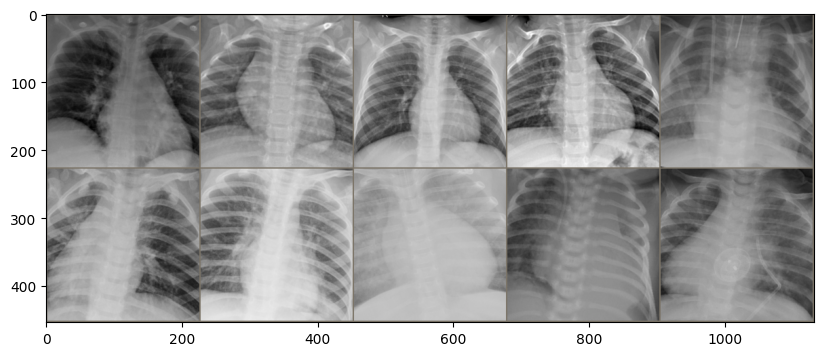

In [15]:
# Display a few images

for images,labels in train_loader:
    break

# Print the labels
print('Label:', labels[:10].numpy())
print('Class:', *np.array([class_names[i] for i in labels[:10]]))

im = make_grid(images[:10], nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));

Training a CNN model from scratch does not work well in this specific use case for two main reasons:



*   Training a model on such large images takes a long time, even for 1 epoch.
*   Even if time was not an issue, we would need a much larger image sample to successfully train a deep neural network. A simple model with 2 convolution layers and 3 fully connected layers has around 5 million parameters, which is 1,000 times less than the available training images and it would definitely result in overfitting.



The solution is to apply **transfer learning**, using a **pre-trained** model. Two models that are widely used in the industry are VGG and ResNet. Both are available through PyTorch. I start by using **VGG16**.

VGG has been trained on the ImageNet dataset. It consists of 13 convolution layers and 3 fully connected layers.



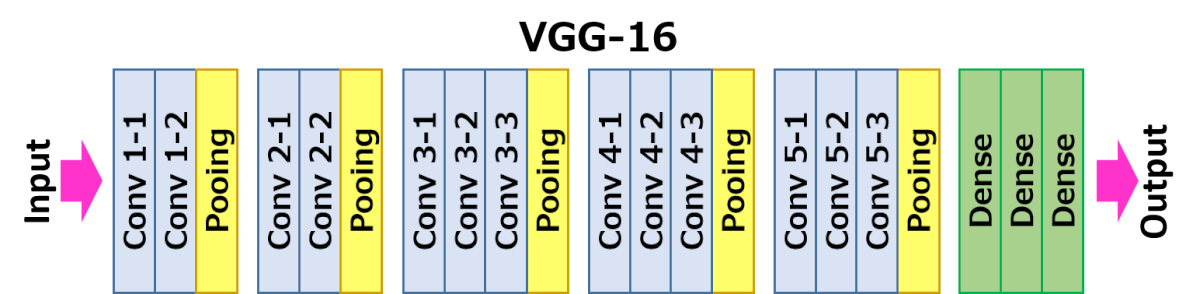

VGG16 Network Architecture (Source: neurohive.io)

The VGG network can be viewed as a combination of two parts:


*   a feature extraction part (feature transformer), followed by
*   a linear model



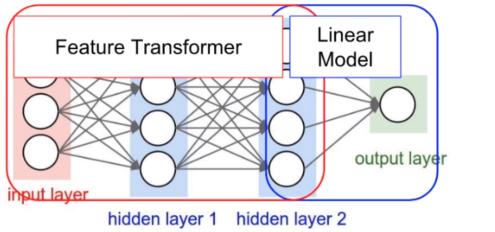

Source: Medium

In order to take advantage of the VGG model architecture, we can use the feature transformer part as is and replace the fully connected layers at the end in order to get the desired output of 2 classes - Normal/Pneumonia (instead of 1,000 ImageNet classes).

As a first pass we will not re-train the VGG weights (this would take a bit longer but would likely increase the accuracy) and just train the final logistic regression.

In [11]:
# Download the pretrained model

vgg16 = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 266MB/s]


In [12]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
# freeze model parameters

for param in vgg16.parameters():
    param.requires_grad = False

In [16]:
# modify the final part of the classifier

vgg16.classifier[6] = nn.Sequential(nn.Linear(4096, 256),
                                    nn.ReLU(),
                                    nn.Dropout(0.4),
                                    nn.Linear(256, 2),
                                    nn.LogSoftmax(dim=1))

vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [17]:
sum([p.numel() for p in vgg16.parameters() if p.requires_grad])

1049346

In [18]:
train_on_gpu = cuda.is_available()

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

if train_on_gpu:
   vgg16 = vgg16.to('cuda')

1 gpus detected.


In [19]:
# define loss and optimization functions

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg16.classifier.parameters())

In [20]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model: cnn to train
        criterion: objective to minimize
        optimizer: optimizer to compute gradients of model parameters
        train_loader: training dataloader to iterate through
        valid_loader: validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
            # calculate test accuracy for each object class
            '''for i in range(batch_size):
                label = target.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1'''

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history


In [21]:
model, history = train(
    vgg16,
    criterion,
    optimizer,
    train_loader,
    test_loader,
    save_file_name='vgg16-chest-1.pt',
    max_epochs_stop=5,
    n_epochs=10,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.2816 	Validation Loss: 0.4357
		Training Accuracy: 87.46%	 Validation Accuracy: 81.56%

Epoch: 1 	Training Loss: 0.1855 	Validation Loss: 0.5223
		Training Accuracy: 92.56%	 Validation Accuracy: 79.06%

Epoch: 2 	Training Loss: 0.1752 	Validation Loss: 0.4062
		Training Accuracy: 92.93%	 Validation Accuracy: 82.50%

Epoch: 3 	Training Loss: 0.1752 	Validation Loss: 0.4700
		Training Accuracy: 93.14%	 Validation Accuracy: 80.62%

Epoch: 4 	Training Loss: 0.1737 	Validation Loss: 0.4018
		Training Accuracy: 92.93%	 Validation Accuracy: 83.44%

Epoch: 5 	Training Loss: 0.1655 	Validation Loss: 0.4595
		Training Accuracy: 93.14%	 Validation Accuracy: 83.12%

Epoch: 6 	Training Loss: 0.1747 	Validation Loss: 0.4040
		Training Accuracy: 93.10%	 Validation Accuracy: 82.50%

Epoch: 7 	Training Loss: 0.1694 	Validation Loss: 0.4804
		Training Accuracy: 93.04%	 Validation Accuracy: 79.38%

Epoch: 8 	Training Loss: 0.1658 	Validation Lo

Text(0.5, 1.0, 'Training and Validation Accuracy')

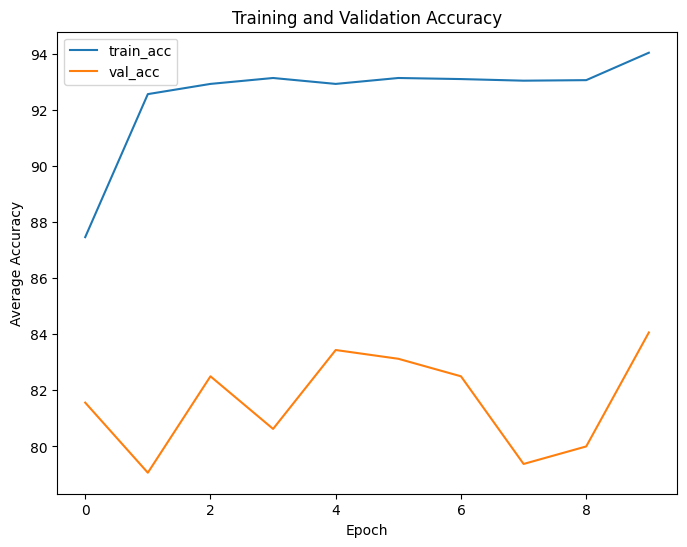

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(100 * history['train_acc'], label='train_acc')
plt.plot(100 * history['valid_acc'], label='val_acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')